In [26]:
#core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter


# environment
import gymnasium as gym
from gymnasium import spaces

# reinforcement learning
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

# styles
plt.style.use('dark_background')

In [27]:
GET_OPTIMAL_N_ENVS = True
BATCH_SIZE = 2048

In [28]:
class YahtzeeEnv(gym.Env):
    def __init__(self):
        super(YahtzeeEnv, self).__init__()
        self.max_turns = 30

        # Action space
        self.action_space = spaces.MultiDiscrete([2]*5 + [13]) #  + [13]

        # State space - 5 dice, 13 score types and rolls left
        self.observation_space = spaces.Dict({
            'dice': spaces.Box(low=1, high=7, shape=(5,), dtype=np.int32), # spaces.MultiDiscrete([6, 6, 6, 6, 6]),
            'scorecard': spaces.Box(low=-1, high=51, shape=(13,), dtype=np.int32),
            'potential_scores': spaces.Box(low=-1, high=51, shape=(13,), dtype=np.int32),
            'target_score': spaces.Discrete(13),
            'rolls_left': spaces.Discrete(3),
            'turn_count': spaces.Discrete(31)
        })

        # Dict to map score types to labels
        self.label_score_dict = {
            0: 'ones', 1: 'twos', 2: 'threes', 3: 'fours', 4: 'fives', 5: 'sixes',
            6: 'three_of_a_kind', 7: 'four_of_a_kind', 8: 'full_house', 9: 'small_straight', 
            10: 'large_straight', 11: 'yahtzee', 12: 'chance'
        }

        # Initialize the game state
        self.reset()

    def reset(self, seed=None, options=None):
        # Set the seed for the environment's random number generator
        super().reset(seed=seed)

        # Reset the game state
        self.dice = np.random.randint(low=1, high=7, size=5)
        self.scorecard = np.ones(13, dtype=np.int8) * -1
        self.potential_scores = np.zeros(13, dtype=np.int8)
        self.target_score = 11
        self.rolls_left = 2
        self.turn_count = 0

        # Optionally return additional info
        info = {}
        if options is not None: 
            info['options'] = options
    
        return self._get_obs(), info

    def step(self, action):
        dice_action = action[:5]
        score_action = action[5]
        # target_score_type = action[6]
        truncated = False

        # Initialize info
        info = {}
        info['dice_before_action'] = self.dice
        info['scorecard'] = self.scorecard
        
        # Dice action
        if self.rolls_left > 0:
            self.dice = np.where(dice_action, self.dice, np.random.randint(low=1, high=7, size=5))
            self.rolls_left -= 1
            reward = self._evaluate_dice_action(dice_action, info['dice_before_action'])
            done = False
            # Store info
            info['action_type'] = 'dice'
            info['dice_action'] = dice_action
            info['rolls_left'] = self.rolls_left
            info['dice_after_action'] = self.dice
        # Score action
        else:
            if self.scorecard[score_action] != -1:  # Only apply the score if the category isn't filled
                reward = -50
            else:
                reward = self._get_score_potentials(self.dice)[score_action] # self._get_score(action)
                self.scorecard[score_action] = reward
            self._reset_turn()
            # Store info
            info['action_type'] = 'score'
            info['score_action'] = self.label_score_dict[score_action]
            info['total_score'] = np.sum(self.scorecard)
            # Check if the game is over / max turns reached
            done = np.all(self.scorecard != -1)
            if self.turn_count >= self.max_turns:
                truncated = True
            else:
                truncated = False

        return self._get_obs(), reward, done, truncated, info
    
    def _get_obs(self):
        return {
            'dice': self.dice, # - 1,
            'scorecard': self.scorecard,
            'potential_scores': np.array([x for x in self._get_score_potentials(self.dice).values()]),
            'target_score': self.target_score,
            'rolls_left': self.rolls_left,
            'turn_count': self.turn_count
        }
    
    def _get_score_potentials(self, dice):
        small_straights = [[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]]
        large_straights = [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]]
        score_potentials = {
            0: np.sum(dice == 1),       # ones
            1: np.sum(dice == 2) * 2,   # twos
            2: np.sum(dice == 3) * 3,   # threes
            3: np.sum(dice == 4) * 4,   # fours
            4: np.sum(dice == 5) * 5,   # fives
            5: np.sum(dice == 6) * 6,   # sixes
            6: sum(dice) if ( np.unique(dice, return_counts = True)[1].max() >= 3) else 0,  # three_of_a_kind
            7: sum(dice) if (np.unique(dice, return_counts = True)[1].max() >= 4) else 0,   # four_of_a_kind
            8: 25 if sorted(np.unique(dice, return_counts=True)[1]) == [2, 3] else 0,       # full_house
            9: 30 if any(all(number in dice for number in subseq) for subseq in small_straights) else 0,    # small_straight
            10: 40 if any(all(number in dice for number in subseq) for subseq in large_straights) else 0,   # large_straight
            11: 50 if len(set(dice)) == 1 else 0,   # yahtzee
            12: sum(dice)                           # chance
        }
        # If a score is already marked, remove it from potential scores
        for score_label in score_potentials.keys():
            if self.scorecard[score_label] != -1:
                score_potentials[score_label] = 0
        return score_potentials
    
    def _evaluate_dice_action(self, dice_action, pre_hand, max_weight=0.7, match_multiplier=2, straight_multiplier=15, penalty_threshold=15):
        # Reward increase in potential score types
        pre_potentials = self._get_score_potentials(pre_hand)
        post_potentials = self._get_score_potentials(self.dice)
        max_pre = max(pre_potentials.values())
        max_post = max(post_potentials.values())
        sum_pre = sum(pre_potentials.values())
        sum_post = sum(post_potentials.values())
        reward = max_weight * (max_post - max_pre) + (1 - max_weight) * (sum_post - sum_pre)
        # Reward keeping matching dice
        highest_match = [(num, count) for num, count in Counter(pre_hand).items() if count == max(Counter(pre_hand).values()) and count > 1]
        if highest_match:
            highest_match = highest_match[0]
            kept_all_matches = len([x for x in range(5) if dice_action[x] == 1 and pre_hand[x] == highest_match[0]]) == highest_match[1]
            is_match_eligible = self.scorecard[highest_match[0]-1] == -1 or self.scorecard[6] == -1 or self.scorecard[7] == -1 or self.scorecard[11] == -1
            match_reward = (highest_match[0] * highest_match[1] * match_multiplier) if kept_all_matches and is_match_eligible else 0
        else:
            match_reward = 0
        # Reward keeping sequences, if straights are available
        possible_subs = [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6]]
        kept_dice = set([pre_hand[i] for i in range(5) if dice_action[i] == 1])
        kept_subs = [sub for sub in possible_subs if all(num in kept_dice for num in sub)]
        is_straight_eligible = self.scorecard[9] == -1 or self.scorecard[10] == -1
        straight_reward = len(kept_subs) * straight_multiplier if is_straight_eligible else 0
        # Penalize chasing both straights and matches, else add reward
        if match_reward > penalty_threshold and straight_reward > penalty_threshold:
            reward = -((match_reward - penalty_threshold) + (straight_reward - penalty_threshold)) * (3 - self.rolls_left)
        else:
            reward += max(match_reward, straight_reward)
        return reward

    def _reset_turn(self):
        self.dice = np.random.randint(low=1, high=7, size=5)
        self.rolls_left = 2
        self.turn_count += 1

    def render(self):
        pass

In [29]:
class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.episode_reward = 0
        self.episode_rewards = []
        self.episode_scores = []

    def _on_step(self) -> bool:
        # Accumulate rewards for the current episode
        reward = self.locals['rewards'][0]
        self.episode_reward += reward
        
        # Check if the episode is done
        done = self.locals['dones'][0]
        if done:
            # Log the total reward for this episode
            self.episode_rewards.append(self.episode_reward)
            self.episode_scores.append(self.locals['infos'][0]['total_score'])
            self.episode_reward = 0  # Reset for the next episode
            
        return True  # Continue training

In [30]:
if GET_OPTIMAL_N_ENVS:

    times = {}

    for n_env in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:

        start = time.time()

        # Create the environment
        env = make_vec_env(YahtzeeEnv, n_envs=n_env)

        # Check if the environment follows the Gymnasium API
        check_env(env.envs[0])

        # Create the RL model
        model = PPO('MultiInputPolicy', env, verbose=0, batch_size=BATCH_SIZE)

        # Train the model
        model.learn(total_timesteps=10000)

        # Save the model
        model.save('ppo_yahtzee')

        # Log time
        elapsed_time = (time.time() - start) / 60
        times[n_env] = elapsed_time
        print(f'Time elapsed with {n_env} environments: {elapsed_time:.2f} minutes')

    optimal_n_env = min(times, key=times.get)
    print(f'Optimal number of environments: {optimal_n_env}')

    plt.plot(pd.DataFrame.from_dict(times, orient='index', columns=['Time']))

In [ ]:
n_timesteps = 10**6 # 10**7
n_env = optimal_n_env if GET_OPTIMAL_N_ENVS else 256

# Create the environment
env = make_vec_env(YahtzeeEnv, n_envs=n_env)
check_env(env)

# Create the callback and RL model
callback = CustomCallback(verbose=1)
model = PPO('MultiInputPolicy', env, verbose=1, batch_size=BATCH_SIZE)

# Train the model
model.learn(total_timesteps=n_timesteps, callback=callback)

# Save the model
model.save('ppo_yahtzee')

NameError: name 'optimal_n_env' is not defined

In [ ]:
len(model.get_parameters()['policy']['action_net.weight'])

23

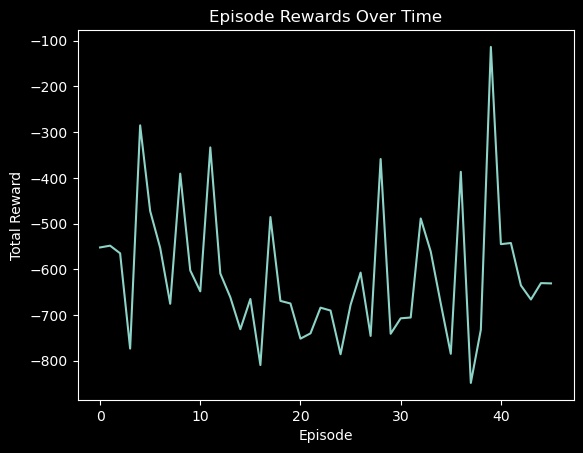

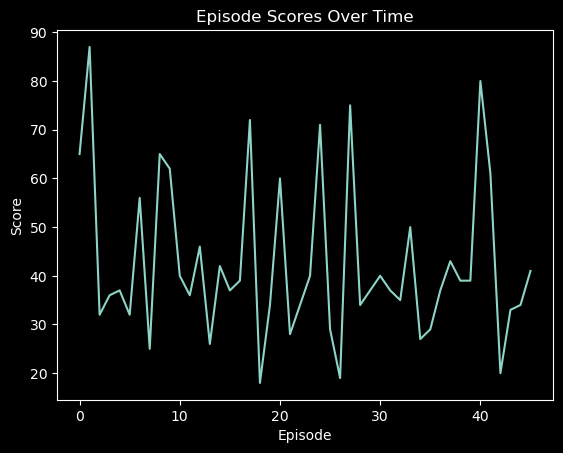

In [ ]:
plt.plot(callback.episode_rewards)
plt.title("Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.plot(callback.episode_scores)
plt.title("Episode Scores Over Time")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

In [ ]:
# Create a new, non-vectorized instance of the Yahtzee environment
eval_env = YahtzeeEnv()

# Reset the environment to get the initial observation
obs, _info = eval_env.reset()

# Set a loop to play a certain number of turns (in this case, 50 turns)
terminated = False
truncated = False
i = 0
while not terminated and not truncated:
# for i in range(100):
    if (i+1) % 3 == 1:
        print(f'\n--  Turn {(i/3)+1:.0f} - Starting Scorecard: {obs["scorecard"]}  --')
    print(f'Dice: {eval_env.dice}') # obs["dice"]

    # Use the model to predict the next action
    action, _states = model.predict(obs, deterministic=True)
    
    # Take a step in the environment with the chosen action
    obs, reward, terminated, truncated, info = eval_env.step(action)

    # Render the current state of the environment (e.g., show dice, scorecard)
    # eval_env.render()
    if (i+1) % 3 == 0:
        print(
            f'Score Action: {info["score_action"]}\n'
            f'Score: {eval_env.scorecard[action[5]]}\n'
            f'Reward: {reward}\n'
            f'Ending Scorecard: {eval_env.scorecard}'
        )
    else:
        print(
            f'Dice Action: {info["dice_action"]}\n'
            f'Reward: {reward}'
        )

    # Check if the episode has ended
    if terminated or truncated:
        # If the episode is done, reset the environment
        obs = eval_env.reset()

    # Increment the turn counter
    i += 1


--  Turn 1 - Starting Scorecard: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]  --
Dice: [2 3 5 5 4]
Dice Action: [1 1 1 1 1]
Reward: -40
Dice: [2 3 5 5 4]
Dice Action: [1 1 1 1 1]
Reward: -60
Dice: [2 3 5 5 4]
Score Action: small_straight
Score: 30
Reward: 30
Ending Scorecard: [-1 -1 -1 -1 -1 -1 -1 -1 -1 30 -1 -1 -1]

--  Turn 2 - Starting Scorecard: [-1 -1 -1 -1 -1 -1 -1 -1 -1 30 -1 -1 -1]  --
Dice: [3 5 1 2 5]
Dice Action: [1 1 1 1 1]
Reward: 20.0
Dice: [3 5 1 2 5]
Dice Action: [1 1 1 1 1]
Reward: 20.0
Dice: [3 5 1 2 5]
Score Action: chance
Score: 16
Reward: 16
Ending Scorecard: [-1 -1 -1 -1 -1 -1 -1 -1 -1 30 -1 -1 16]

--  Turn 3 - Starting Scorecard: [-1 -1 -1 -1 -1 -1 -1 -1 -1 30 -1 -1 16]  --
Dice: [4 3 1 1 1]
Dice Action: [0 1 1 1 1]
Reward: 3.4
Dice: [2 3 1 1 1]
Dice Action: [0 1 1 1 1]
Reward: 6.800000000000001
Dice: [1 3 1 1 1]
Score Action: ones
Score: 4
Reward: 4
Ending Scorecard: [ 4 -1 -1 -1 -1 -1 -1 -1 -1 30 -1 -1 16]

--  Turn 4 - Starting Scorecard: [ 4 -1 -1 -1 -1 -1 -1 